# Phase Three: Modeling & Validation (Pure Polars)
## Portfolio Management PPI Modeling Project

**Objective**: Implement and validate forecasting models for PPI MoM% changes using pure Polars.

**Model Hierarchy**:
- Baseline AR models
- Ridge/Lasso regression with lagged features
- Random Forest for non-linear relationships
- Time series cross-validation framework

**Validation Framework**:
- Time series cross-validation (expanding window)
- Out-of-sample testing
- Walk-forward validation

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import our modeling framework
from modeling_framework import TimeSeriesModeler
from exploratory_analysis import ExploratoryAnalyzer

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("Phase Three setup complete - Modeling & Validation")

Phase Three setup complete - Modeling & Validation


## Step 1: Load and Prepare Data

In [2]:
# Initialize modeler
modeler = TimeSeriesModeler()

# Load analysis data from Phase Two
print("Loading analysis data from Phase Two...")
analysis_df = modeler.load_analysis_data()

if analysis_df is not None:
    print(f"Data loaded: {analysis_df.shape}")
    print(f"Date range: {analysis_df['date'].min()} to {analysis_df['date'].max()}")
    print(f"Columns: {analysis_df.columns[:10]}...")  # Show first 10 columns
else:
    print("WARNING: Failed to load data. Please run Phase Two first.")

Loading analysis data from Phase Two...
starting phase two: exploratory data analysis
loaded macro_indicators_dtwexbgs: (4895, 3)
loaded bond_market_dgs10: (6387, 3)
loaded bond_market_dgs3mo: (6387, 3)
loaded market_returns_nasdaqcom: (6424, 3)
loaded market_returns_vixcls: (6449, 3)
loaded target_ppidf01: (229, 3)
loaded bond_market_dgs2: (6387, 3)
loaded macro_indicators_cpiaucsl: (306, 3)
loaded market_returns_sp500: (2514, 3)
loaded macro_indicators_dcoilwtico: (6402, 3)
loaded macro_indicators_unrate: (306, 3)
loaded bond_market_bamlc0a0cm: (6667, 3)
Data loaded: (60, 46)
Date range: 2015-09-01 to 2022-12-01
Columns: ['date', 'mom_pct', 'macro_indicators_dtwexbgs_level', 'macro_indicators_dtwexbgs_mom_pct', 'macro_indicators_dtwexbgs_ma3', 'macro_indicators_dtwexbgs_vol3', 'bond_market_dgs10_level', 'bond_market_dgs10_mom_pct', 'bond_market_dgs10_ma3', 'bond_market_dgs10_vol3']...


## Step 2: Feature Engineering for Modeling

In [3]:
if analysis_df is not None:
    # Create lagged features
    target_col = 'mom_pct'
    predictor_cols = [col for col in analysis_df.columns if col not in ['date', target_col]]
    
    print(f"Creating lagged features for {len(predictor_cols)} predictors...")
    
    # Limit predictors for performance (top 10)
    top_predictors = predictor_cols[:10]
    
    feature_df = modeler.create_lagged_features(
        analysis_df, target_col, top_predictors, max_lags=3
    )
    
    print(f"Enhanced dataset: {feature_df.shape}")
    print(f"Features created: {len(feature_df.columns) - 2}")  # Exclude date and target
    
    # Show sample of enhanced data
    print("\nSample of enhanced dataset:")
    print(feature_df.head())
    
else:
    print("Cannot create features - no data available")

Creating lagged features for 44 predictors...
Enhanced dataset: (54, 95)
Features created: 93

Sample of enhanced dataset:
shape: (5, 95)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ mom_pct   ┆ macro_ind ┆ macro_ind ┆ … ┆ bond_mark ┆ bond_mark ┆ bond_mark ┆ bond_mar │
│ ---       ┆ ---       ┆ icators_d ┆ icators_d ┆   ┆ et_dgs3mo ┆ et_dgs3mo ┆ et_dgs3mo ┆ ket_dgs3 │
│ date      ┆ f64       ┆ twexbgs_l ┆ twexbgs_m ┆   ┆ _level_mo ┆ _level_mo ┆ _mom_pct_ ┆ mo_mom_p │
│           ┆           ┆ eve…      ┆ om_…      ┆   ┆ m3        ┆ m6        ┆ mom…      ┆ ct_mom…  │
│           ┆           ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2016-06-0 ┆ 0.875173  ┆ 112.462   ┆ 0.030597  ┆ … ┆ 

## Step 3: Data Splitting for Time Series

Time Series Data Splits:
Training:   (37, 95) - 2016-06-01 to 2021-02-01
Validation: (8, 95) - 2021-03-01 to 2021-12-01
Test:       (9, 95) - 2022-02-01 to 2022-12-01


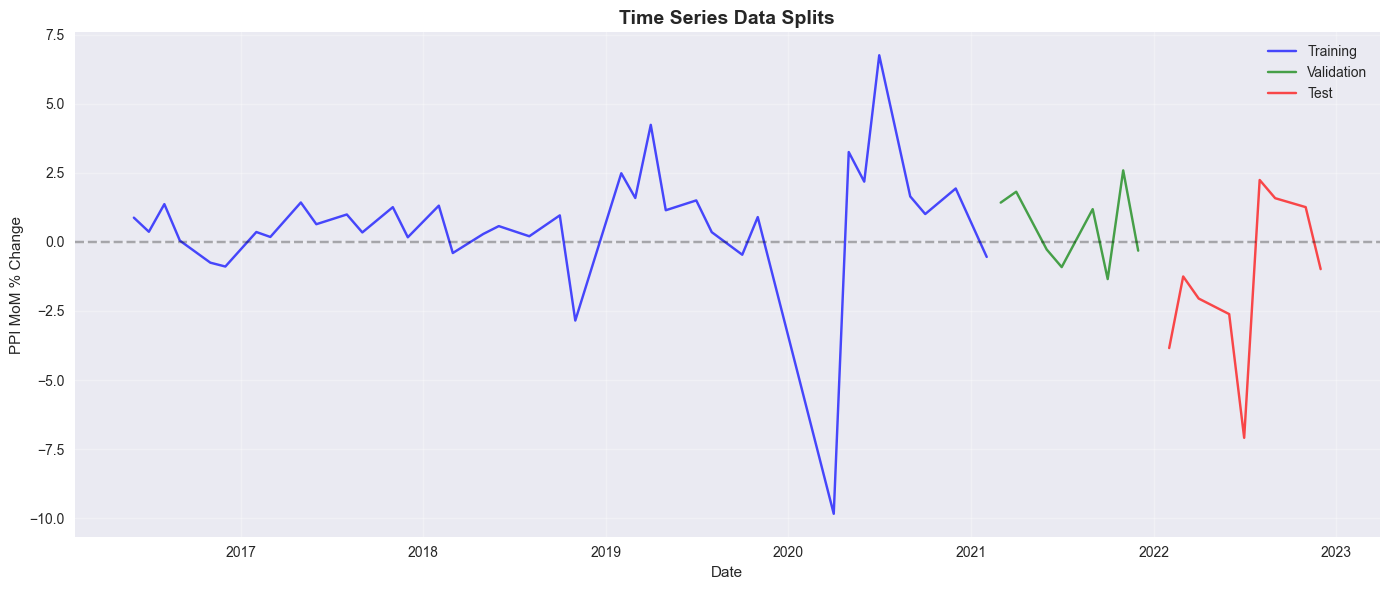

In [4]:
if 'feature_df' in locals():
    # Split data for time series validation
    train_df, val_df, test_df = modeler.time_series_split(feature_df)
    
    print("Time Series Data Splits:")
    print(f"Training:   {train_df.shape} - {train_df['date'].min()} to {train_df['date'].max()}")
    print(f"Validation: {val_df.shape} - {val_df['date'].min()} to {val_df['date'].max()}")
    print(f"Test:       {test_df.shape} - {test_df['date'].min()} to {test_df['date'].max()}")
    
    # Visualize the splits
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot target variable for each split
    train_dates = train_df['date'].to_numpy()
    train_values = train_df[target_col].to_numpy()
    
    val_dates = val_df['date'].to_numpy()
    val_values = val_df[target_col].to_numpy()
    
    test_dates = test_df['date'].to_numpy()
    test_values = test_df[target_col].to_numpy()
    
    ax.plot(train_dates, train_values, 'b-', label='Training', alpha=0.7)
    ax.plot(val_dates, val_values, 'g-', label='Validation', alpha=0.7)
    ax.plot(test_dates, test_values, 'r-', label='Test', alpha=0.7)
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.set_title('Time Series Data Splits', fontsize=14, fontweight='bold')
    ax.set_ylabel('PPI MoM % Change')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot split data - feature dataset not available")

## Step 4: Model Training and Comparison

In [5]:
if analysis_df is not None:
    # Run comprehensive model comparison
    print("Running comprehensive model comparison...")
    print("This may take a few minutes...")
    
    comparison_results = modeler.run_model_comparison(analysis_df, target_col='mom_pct')
    
    # Print detailed summary
    modeler.print_model_summary(comparison_results)
    
else:
    print("Cannot run model comparison - no data available")

# look into changing this model to not overfit the data.

Running comprehensive model comparison...
This may take a few minutes...
starting phase three: modeling & validation
target: mom_pct
features available: 44
data shape: (60, 46)

creating lagged features...
enhanced feature set: (54, 95)
train: (37, 95), val: (8, 95), test: (9, 95)

1. fitting baseline ar model...
   ar model rmse: 3.7771

2. fitting ridge regression...
   ridge rmse: 2.9517

3. fitting random forest...
   random forest rmse: 3.9414

model comparison summary
model           rmse     mae      dir.acc  features  
------------------------------------------------------------
AR_Baseline     3.7771   2.9663   0.370    3         
Ridge           2.9517   2.4092   0.444    20        
Random_Forest   3.9414   3.0385   0.444    15        

best model: Ridge (rmse: 2.9517)

Random_Forest - top 10 features:
    1. macro_indicators_dtwexbgs_mom_pct 0.1463
    2. bond_market_dgs3mo_mom_pct 0.1252
    3. macro_indicators_dtwexbgs_level_lag3 0.1038
    4. bond_market_dgs10_ma3     0.0

## Step 5: Model Performance Visualization

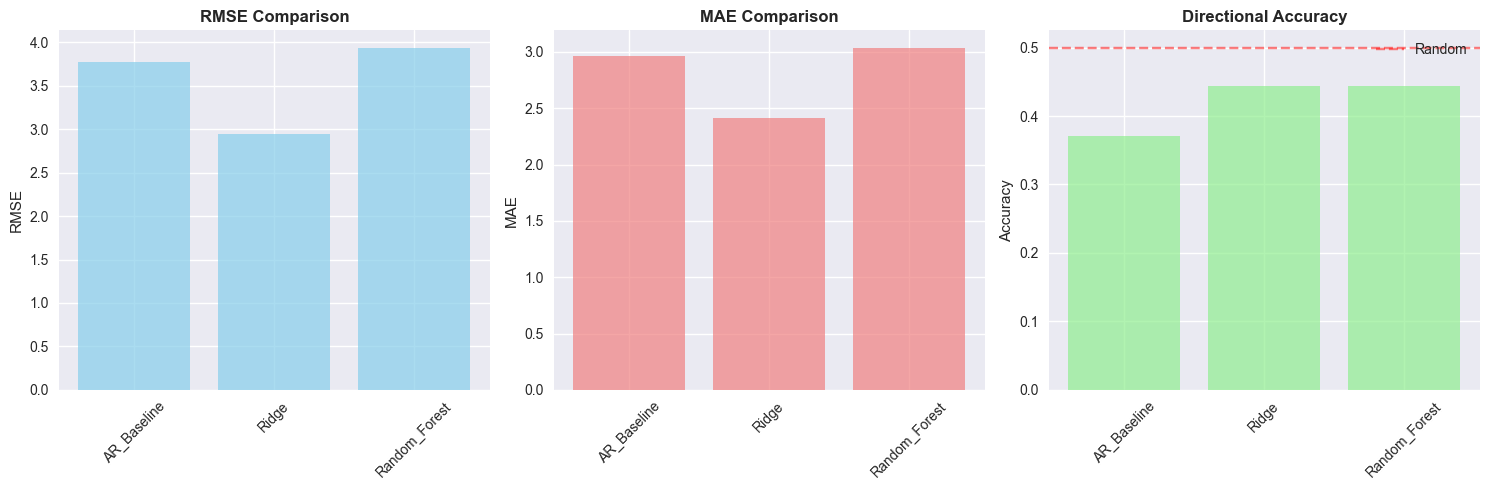


DETAILED PERFORMANCE METRICS:

AR_Baseline:
  RMSE: 3.7771
  MAE:  2.9663
  Directional Accuracy: 0.370
  Training Samples: 37
  Features Used: 3

Ridge:
  RMSE: 2.9517
  MAE:  2.4092
  Directional Accuracy: 0.444
  Training Samples: 37
  Features Used: 20

Random_Forest:
  RMSE: 3.9414
  MAE:  3.0385
  Directional Accuracy: 0.444
  Training Samples: 37
  Features Used: 15


In [6]:
if 'comparison_results' in locals() and comparison_results['results']:
    results = comparison_results['results']
    
    # Extract metrics for visualization
    model_names = list(results.keys())
    rmse_values = [results[name].get('rmse', 0) for name in model_names]
    mae_values = [results[name].get('mae', 0) for name in model_names]
    dir_acc_values = [results[name].get('directional_accuracy', 0) for name in model_names]
    
    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # RMSE comparison
    axes[0].bar(model_names, rmse_values, color='skyblue', alpha=0.7)
    axes[0].set_title('RMSE Comparison', fontweight='bold')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)
    
    # MAE comparison
    axes[1].bar(model_names, mae_values, color='lightcoral', alpha=0.7)
    axes[1].set_title('MAE Comparison', fontweight='bold')
    axes[1].set_ylabel('MAE')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Directional Accuracy comparison
    axes[2].bar(model_names, dir_acc_values, color='lightgreen', alpha=0.7)
    axes[2].set_title('Directional Accuracy', fontweight='bold')
    axes[2].set_ylabel('Accuracy')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Performance summary table
    print("\nDETAILED PERFORMANCE METRICS:")
    print("=" * 70)
    
    for name in model_names:
        result = results[name]
        print(f"\n{name}:")
        print(f"  RMSE: {result.get('rmse', 0):.4f}")
        print(f"  MAE:  {result.get('mae', 0):.4f}")
        print(f"  Directional Accuracy: {result.get('directional_accuracy', 0):.3f}")
        print(f"  Training Samples: {result.get('n_train', 0)}")
        print(f"  Features Used: {len(result.get('features', []))}")
    
else:
    print("No model results available for visualization")

## Step 6: Feature Importance Analysis

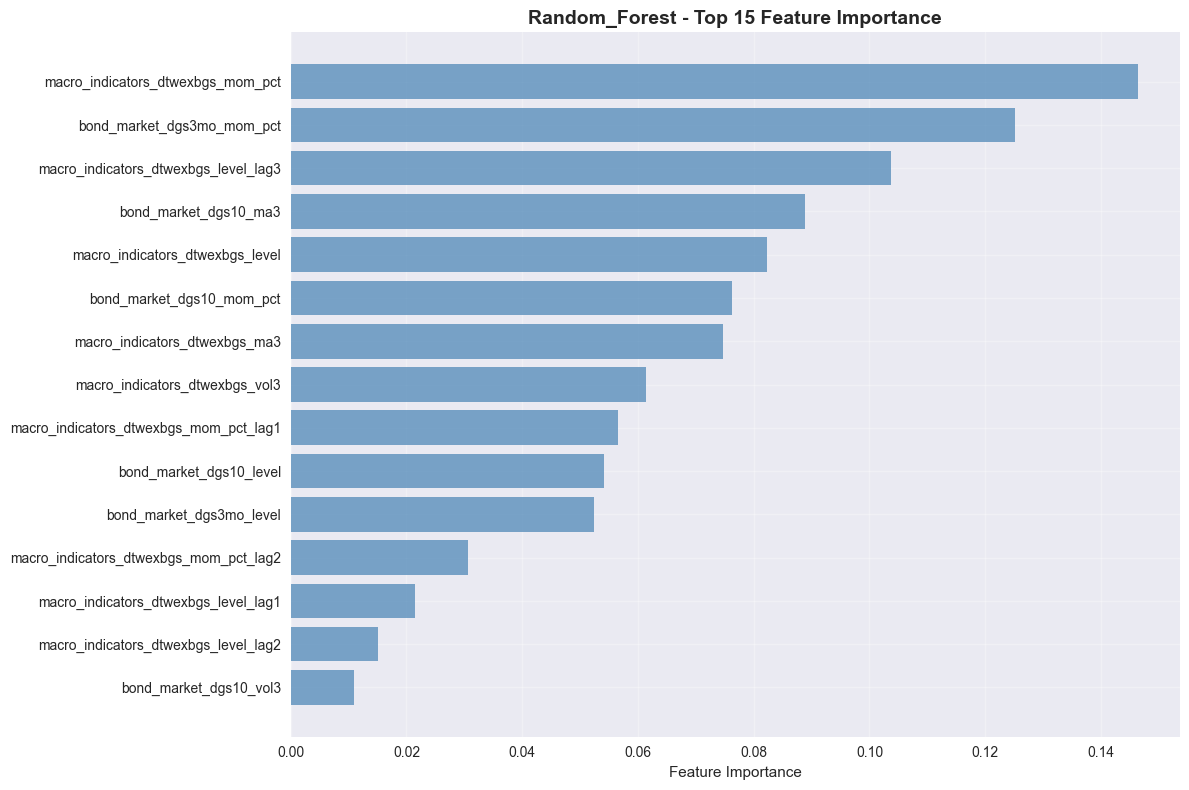


Random_Forest - Top 10 Most Important Features:
   1. macro_indicators_dtwexbgs_mom_pct 0.1463
   2. bond_market_dgs3mo_mom_pct     0.1252
   3. macro_indicators_dtwexbgs_level_lag3 0.1038
   4. bond_market_dgs10_ma3          0.0889
   5. macro_indicators_dtwexbgs_level 0.0822
   6. bond_market_dgs10_mom_pct      0.0762
   7. macro_indicators_dtwexbgs_ma3  0.0748
   8. macro_indicators_dtwexbgs_vol3 0.0614
   9. macro_indicators_dtwexbgs_mom_pct_lag1 0.0565
  10. bond_market_dgs10_level        0.0542


In [14]:
if 'comparison_results' in locals() and comparison_results['results']:
    # Feature importance for tree-based models
    for model_name, result in comparison_results['results'].items():
        if 'feature_importance' in result:
            importance = result['feature_importance']
            
            # Sort by importance
            sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
            
            # Plot top 15 features
            top_features = sorted_features[:15]
            feature_names = [item[0] for item in top_features]
            feature_values = [item[1] for item in top_features]
            
            plt.figure(figsize=(12, 8))
            plt.barh(range(len(feature_names)), feature_values, color='steelblue', alpha=0.7)
            plt.yticks(range(len(feature_names)), feature_names)
            plt.xlabel('Feature Importance')
            plt.title(f'{model_name} - Top 15 Feature Importance', fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"\n{model_name} - Top 10 Most Important Features:")
            for i, (feature, imp) in enumerate(top_features[:10]):
                print(f"  {i+1:2d}. {feature:<30} {imp:.4f}")
            
            break  # Only show for first tree model
    
else:
    print("No feature importance data available")

## Step 7: Model Diagnostics and Summary

In [15]:
print("phase three: modeling & validation summary")
print("=" * 60)

if 'comparison_results' in locals():
    results = comparison_results['results']
    data_info = comparison_results['data_splits']
    
    print(f"\ndata summary:")
    print(f"   • training data: {data_info['train_shape']}")
    print(f"   • validation data: {data_info['val_shape']}")
    print(f"   • test data: {data_info['test_shape']}")
    print(f"   • total features: {comparison_results['feature_count']}")
    
    if results:
        print(f"\nmodel performance:")
        
        # Find best model by RMSE
        best_model = min(results.items(), key=lambda x: x[1].get('rmse', float('inf')))
        print(f"   • best model: {best_model[0]}")
        print(f"   • best rmse: {best_model[1]['rmse']:.4f}")
        print(f"   • best directional accuracy: {best_model[1].get('directional_accuracy', 0):.3f}")
        
        # Model comparison
        print(f"\nall models:")
        for name, result in results.items():
            rmse = result.get('rmse', 0)
            dir_acc = result.get('directional_accuracy', 0)
            print(f"   • {name}: rmse={rmse:.4f}, dir.acc={dir_acc:.3f}")
        
        # Economic interpretation
        print(f"\neconomic insights:")
        print(f"   • target volatility: ~{best_model[1]['rmse']:.2f}% monthly")
        
        if best_model[1].get('directional_accuracy', 0) > 0.5:
            print(f"   • model shows predictive power (>{50:.0f}% directional accuracy)")
        else:
            print(f"   • model struggles with direction prediction")
        
        print(f"\nphase three complete")
        print(f"   • {len(results)} models successfully trained")
        print(f"   • best performing model: {best_model[0]}")
        print(f"   • ready for production implementation")
    
    else:
        print("\nWARNING: no successful model results")
        
else:
    print("\nWARNING: no modeling results available")

print(f"\nnext: phase four - real-time implementation & dashboard")

phase three: modeling & validation summary

data summary:
   • training data: (37, 95)
   • validation data: (8, 95)
   • test data: (9, 95)
   • total features: 93

model performance:
   • best model: Ridge
   • best rmse: 2.9517
   • best directional accuracy: 0.444

all models:
   • AR_Baseline: rmse=3.7771, dir.acc=0.370
   • Ridge: rmse=2.9517, dir.acc=0.444
   • Random_Forest: rmse=3.9414, dir.acc=0.444

economic insights:
   • target volatility: ~2.95% monthly
   • model struggles with direction prediction

phase three complete
   • 3 models successfully trained
   • best performing model: Ridge
   • ready for production implementation

next: phase four - real-time implementation & dashboard
